In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. DATENVORBEREITUNG (für alle Schadstoffe)
# ==========================================
# (Angenommen, dein DataFrame heißt 'df')

# Ggf. Pfad zur Datei anpassen
data_path = Path.cwd() / "Luftqualitaet_Zusammenfassung.csv"
#data_path = Path.cwd() / "raw_data_2" / "Luftqualitaet_Zusammenfassung.csv"

# Mapping der Spaltennamen anwenden
df = pd.read_csv(data_path, encoding="UTF-8", sep=";")
df = df.rename(
    columns={
        "Stationscode": "code",
        "Stationsname": "name",
        "Stationsumgebung": "area",
        "Art der Station": "type",
        "Timestamp": "timestamp",
        "Einheit": "unit",
        "Feinstaub (PM₁₀)": "pm10",
        "Feinstaub (PM₂,₅)": "pm25",
        "Kohlenmonoxid (CO)": "co",
        "Ozon (O₃)": "o3",
        "Schwefeldioxid (SO₂)": "so2",
        "Stickstoffdioxid (NO₂)": "no2",
    }
)
df = df.drop(columns=["co"])

# Definiere deine Schadstoff-Spalten
pollutant_cols = ["pm10", "pm25", "o3", "so2", "no2"]

# to numeric, coerce errors to NaN
for col in pollutant_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Stelle sicher, dass timestamp ein Datetime-Objekt ist
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["time"] = df["timestamp"].dt.time
df["date"] = df["timestamp"].dt.date
df["Stunde"] = df["timestamp"].dt.hour

# Berechne den Tagesmittelwert für ALLE Schadstoffe auf einmal
# Wir gruppieren nach dem genauen Datum (ohne Uhrzeit)
daily_data = df.groupby(df["timestamp"].dt.date)[pollutant_cols].mean().reset_index()

# Spalte wieder in ein sauberes Datetime-Format umwandeln und umbenennen
daily_data.rename(columns={"timestamp": "Datum"}, inplace=True)
daily_data["Datum"] = pd.to_datetime(daily_data["Datum"])

# Extrahiere Monat und Tag für das Raster
daily_data["Monat"] = daily_data["Datum"].dt.month
daily_data["Tag"] = daily_data["Datum"].dt.day

# Mappe die Monatszahlen auf echte Monatsnamen
monatsnamen = {
    1: "Januar", 2: "Februar", 3: "März", 4: "April", 
    5: "Mai", 6: "Juni", 7: "Juli", 8: "August", 
    9: "September", 10: "Oktober", 11: "November", 12: "Dezember"
}


/var/folders/1y/b928j3z917s1tz2f3wl_3m5r0000gn/T/ipykernel_1413/3054522662.py:16: DtypeWarning: Columns (0: Feinstaub (PM₂,₅), 1: Kohlenmonoxid (CO), 2: Ozon (O₃), 3: Schwefeldioxid (SO₂)) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding="UTF-8", sep=";")


In [37]:
# Stelle sicher, dass die 'timestamp'-Spalte ein echtes Datetime-Objekt ist
# df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extrahiere die Stunde in eine neue Spalte (0-23)
# df['Stunde'] = df['timestamp'].dt.hour

# Definiere, welche Spalten die Schadstoffe enthalten
# schadstoffe = ['pm10', 'pm25', 'o3', 'so2', 'no2']

# Bringe das DataFrame mit melt() in das Long-Format
# id_vars: Spalten, die erhalten bleiben sollen
# value_vars: Die Spalten, die untereinander geschrieben werden sollen
df_melted = df.melt(
    id_vars=["Stunde", "name", "area", "type"], # 'timestamp' brauchen wir hierfür nicht zwingend
    value_vars=pollutant_cols,
    var_name="Schadstoff", 
    value_name="Konzentration"
)

# Optional: NaNs entfernen, da sie beim Plotten ohnehin ignoriert werden,
# aber das Bereinigen macht das DataFrame schlanker.
df_melted = df_melted.dropna(subset=["Konzentration"])

# Optional: Namen der Schadstoffe für die Legende verschönern (Großschreibung etc.)
schadstoff_mapping = {
    "pm10": "PM10",
    "pm25": "PM2.5",
    "o3": "Ozon (O3)",
    "so2": "Schwefeldioxid (SO2)",
    "no2": "Stickstoffdioxid (NO2)"
}
df_melted["Schadstoff"] = df_melted["Schadstoff"].replace(schadstoff_mapping)


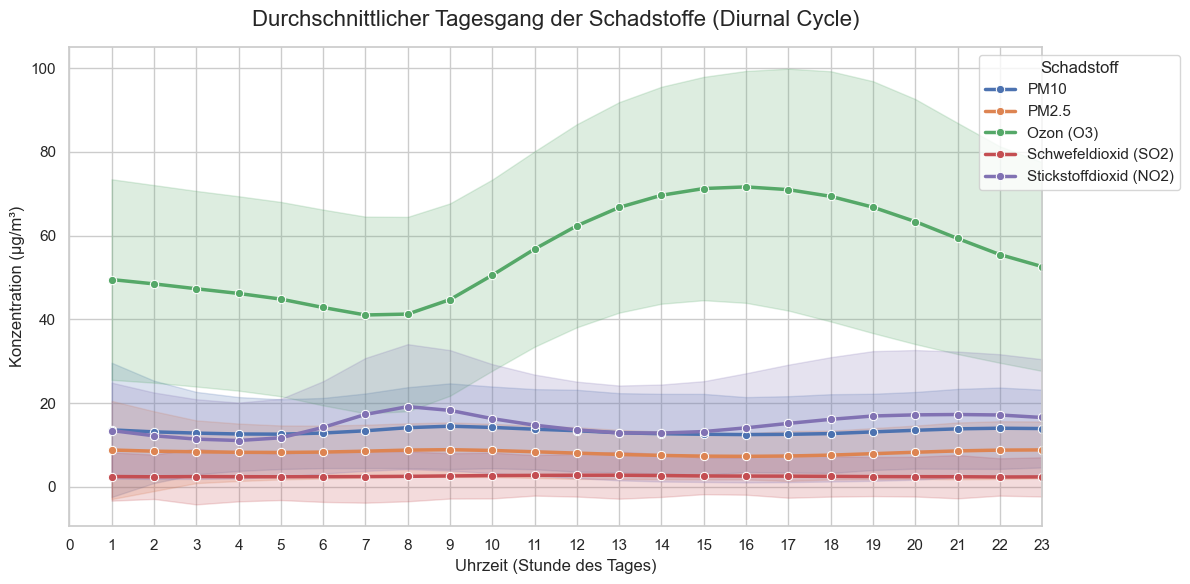

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ==========================================
# 2. GRAFIK ERSTELLEN
# ==========================================
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Liniendiagramm erstellen
# seaborn gruppiert automatisch nach 'Stunde' und 'Schadstoff' und berechnet den Durchschnitt
ax = sns.lineplot(
    data=df_melted, 
    x="Stunde", 
    y="Konzentration", 
    hue="Schadstoff",
    errorbar="sd",     # 'sd' = Standardabweichungs-Band; alternativ 'ci' für Konfidenzintervall oder None
    linewidth=2.5,
    marker="o",        # Setzt Punkte auf die vollen Stunden für bessere Lesbarkeit
    markersize=6
)

# Achsenbeschriftungen und Titel
plt.title("Durchschnittlicher Tagesgang der Schadstoffe (Diurnal Cycle)", fontsize=16, pad=15)
plt.xlabel("Uhrzeit (Stunde des Tages)", fontsize=12)
plt.ylabel("Konzentration (µg/m³)", fontsize=12)

# X-Achse formatieren: 0 bis 23 im 1-Stunden-Takt
plt.xticks(np.arange(0, 24, 1))
plt.xlim(0, 23)

# Legende außerhalb oder schön platziert
plt.legend(title="Schadstoff", title_fontsize="12", loc="upper right", bbox_to_anchor=(1.15, 1))

# Layout optimieren, damit die Legende nicht abgeschnitten wird
plt.tight_layout()

# Grafik anzeigen
plt.show()